Catboost SHAP and prediction plot

1) Figure 4. Actual vs model predicted results for test day (June 9, 2018) for (a) Psychology, (b) Psychology North, and (c) ISTB 4.

2) Figure 5. Feature importance values for tuned model

3) 3 SHAP

4) Figure 9. Scenario predictions for 0.5 degree Celsius reduction in air temperature for (a) Psychology, (b) Psychology North, and (c) ISTB 4.

# 1. Import libraries and files

In [1]:
import pandas as pd
import numpy as np

# models
from sklearn.ensemble import RandomForestRegressor
# uncomment to install the three models below >>>>>
# !pip3 install catboost
from catboost import CatBoostRegressor

# processing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold

# scoring
import math
from sklearn.metrics import r2_score, mean_squared_error

# viz
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import figure

# explain
import shap
import datetime


# import from previous notebook
import nbimporter
import Model8_four_models as FourModels

# import model
import pickle
import lightgbm
import os

In [16]:
# required files
TRAIN_PATH = "../Data/microclimate_model/Combined/three_bldgs_dropped.csv"
TEST_PATH = "../Data/microclimate_model/Combined/three_bldgs_J9_dropped.csv"
OUTPUT_PATH = "./output/"

# >> enter the model we want to plot here
MODEL_NAME = "catboost_random"
DROP_ISTB = True
# <<<<<<

MODEL_SUFFIX = ".sav"
if "lgbm" in MODEL_NAME:
    MODEL_SUFFIX = ".txt"
    
MODEL_PATH = "./output/model/" + MODEL_NAME + MODEL_SUFFIX


# 2. Plot class

In [17]:
class Plot():
    def __init__(self, train_path, test_path):
        """
        The constructor will take the file path and create a df with only bldgname as the column.
        So we will only have the following column when plotting:
        ["bldgname", "y_pred", "y_actual" or "y_scenario_prediction"]
        """
        
        def undummify(df, prefix_sep="_"):
            """
            Inner function to undummify pandas df
            
            Return:
                undummified_df: the undummied df containing only date_time as index and bldgname column
            """
            cols2collapse = {
                item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
            }
            series_list = []
            for col, needs_to_collapse in cols2collapse.items():
                if needs_to_collapse:
                    undummified = (
                        df.filter(like=col)
                        .idxmax(axis=1)
                        .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                        .rename(col)
                    )
                    series_list.append(undummified)
                else:
                    series_list.append(df[col])
            undummified_df = pd.concat(series_list, axis=1)
            return undummified_df
        
        
        # 1. create df undumify df that has bldgnmae and index
        # we will use this df for plotting
        data_istb4 = FourModels.Data(train_path, test_path, isDropISTB=False)
        X_test_istb4, y_test_istb4 = data_istb4.get_xy_test()
        self.df_undum = undummify(X_test_istb4)
        
        # - drop all the columns apart from bldgname with date_time as index
        cols_to_keep = ["bldgname"]
        self.df_undum = self.df_undum.drop(self.df_undum.columns.difference(cols_to_keep), 1)
        
        
        # 2. create df_bldgs pred and actual
        self.df_bldgs = []
        
        
    def get_df_bldgs(self):
        return self.df_bldgs
    
    
    def plot(self, y_pred, y_actual_or_scen, 
             scene_name, 
             output_path="",
             is_scenario=False, 
             is_save=False):
        
            
        # 1. create a copy
        df_undum = self.df_undum.copy()
        
        # 2. assign the first column name
        first_plot_name = "Predicted"
        df_undum[first_plot_name] = y_pred
        
        
        # 3. assign the second column name
        if is_scenario :
            second_plot_name = "Scenario Prediction"
        else:
            second_plot_name = "Actual"

        df_undum[second_plot_name] = y_actual_or_scen
        
        # 4. reformat date index for plotting
        format_before = '%Y-%m-%d %H:%M:%S'
        format_after = '%H:%M'
        df_undum.index = pd.to_datetime(df_undum.index, 
                                        format = format_before).strftime(format_after)
     
        # 4. for each bldgname, compute the difference, 
        for bldgname in df_undum['bldgname'].unique():
            
            # A. get df by bldg
            df_bldg = df_undum[df_undum['bldgname'] == bldgname]
            avg_diff = 0
            
            # B. compute the difference
            if is_scenario :
                # (scenario - predicted) / predicted
                avg_diff = round(((df_bldg[second_plot_name].mean() - 
                            df_bldg[first_plot_name].mean())/df_bldg[first_plot_name].mean())*100,2)
            else: 
                # (predicted - actual) / actual
                avg_diff = round(((df_bldg[first_plot_name].mean() - 
                            df_bldg[second_plot_name].mean())/df_bldg[second_plot_name].mean())*100,2) 
                
                # - save this df
                self.df_bldgs.append(df_bldg)
            
            # C. predicted plot
            
            ax = df_bldg.plot(y = first_plot_name, label = first_plot_name, 
                        ylabel = 'CHWTON/SQM', title = bldgname + "    [Avg Diff:  " + str(avg_diff) + ' %]')
            
            # D. second plot: Scenario or actual
            df_bldg.plot(y = second_plot_name, label = second_plot_name, ax=ax)
            
            
            # E. save images
            if is_save:
                # "./output/predictions_plot/"+ scene_name + "/"
                save_path = output_path + "predictions_plot/"+ scene_name + "/"
                isExist = os.path.exists(save_path)
                if not isExist:

                   # Create a new directory because it does not exist
                   os.makedirs(save_path)
                
                fig = ax.get_figure()
                fig.savefig(save_path + bldgname +'_' + scene_name + '.png')

# 3. Scenario class

In [18]:
"""
This class encapsulates the different scenarios that will be applied to our original data.
We only want to make changes of 0.5 in Air temperature, 0.5 absolute humidity, and 0.2 in shades.
"""
class Scenario():
    def __init__(self, X_test, model):
        # model used to predict
        self.model = model
        
        # data
        # X_test has ISTB_4 if model is CB so we can make scenario prediction
        self.X_test = X_test.copy()
        
        # scenarios
        self.AirTdelta = -0.5 # temperature change
        self.AbsHdelta = -0.5 # absolute humidity
        self.shadeDelta = 0.2
        
    def get_scenario_prediction(self, scenario):
        """
        Given a scenario as a string, this function will make corresponding changes to the X_test dataframe
        and then make prediction using the model initialized in constructor.
        
        Parameter:
            scenario(String) : the variable we want to change in this scenario
            
        Return:
            y_pred_scene : the prediction result
        """
        
        # make copy of X_test_scene so we don't change the actual X_test
        X_test_scene = self.X_test.copy()
        
        # 1. modify X_test according to new scenario
        if scenario == "Air Temp":
            X_test_scene[scenario] += self.AirTdelta
            
        elif scenario == "Abs Hum":
            X_test_scene[scenario] += self.AbsHdelta
        
        elif ("Shade" in scenario):
            print("shade scenario")
            X_test_scene[scenario] += self.shadeDelta
            X_test_scene.loc[X_test_scene[scenario] > 1, scenario] = 1
                
        elif (scenario == "combined"):
            # Air Temp and Abs Hum
            X_test_scene['Air Temp'] = X_test_scene['Air Temp'] + self.AirTdelta
            X_test_scene['Abs Hum'] = X_test_scene['Abs Hum'] + self.AbsHdelta

            # Shading
            shadred = 0.2
            shadcol = ['Shade East', 'Shade West', 'Shade North', 'Shade South']
            for facade in shadcol: 
                X_test_scene[facade] = X_test_scene[facade] + shadred
                X_test_scene.loc[X_test_scene[facade] + shadred > 1, facade] = 1
                
        # 2. make prediction
        y_pred_scene = self.model.predict(X_test_scene)
        return y_pred_scene

# 4. Scoring Class

In [19]:
class Scoring():
    
    def __init__(self):
        # create df to store scores per bldg
        columns=['model','bldgname', 'r2', 'rmse','mbe']
        self.df_scores_per_bldg= pd.DataFrame(columns=columns)
        
    def get_df_scores_per_bldg(self):
        return self.df_scores_per_bldg
    
    def get_MBE(self, y_true, y_pred):
        '''
        Parameters:
            y_true (array): Array of observed values
            y_pred (array): Array of prediction values

        Returns:
            mbe (float): Bias score
        '''
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        y_true = y_true.reshape(len(y_true),1)
        y_pred = y_pred.reshape(len(y_pred),1)   
        diff = (y_pred-y_true)
        mbe = diff.mean()
        return mbe
    
    def compute_R2_MBE_RMSE(self, df, model_name):
        y_actual = df["Actual"]
        y_pred = df["Predicted"]
        
        # 1. get the three scores
        r2 = r2_score(y_actual, y_pred)
        rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
        mbe = self.get_MBE(y_actual, y_pred)
        
        # 2. append score
        # - scores_df to display the scores for all our models
        new_row_data = {'model': model_name, 
                        "bldgname": df.iloc[0,0], 
                        "r2": r2, 
                        'rmse': rmse, 
                        'mbe': mbe}
        new_row = pd.DataFrame.from_records([new_row_data])
        self.df_scores_per_bldg = pd.concat([self.df_scores_per_bldg, new_row])

    

# 5. Import Data and Model

In [20]:
# 1. Load data
data_drop = FourModels.Data(TRAIN_PATH, TEST_PATH, isDropISTB=DROP_ISTB)
X_train_val, y_train_val = data_drop.get_xy_trainval()
X_test, y_test= data_drop.get_xy_test()



In [21]:
# 2. Load Model
if "lgbm" in MODEL_NAME:
    print("model path=", MODEL_PATH)
    model = lightgbm.Booster(model_file=MODEL_PATH)
else:
    model = pickle.load(open(MODEL_PATH, 'rb'))



In [22]:
# 3. test and confirm correct score
tt = FourModels.TrainTest(X_train_val, y_train_val, X_test, y_test)
tt.test_and_store_score(model, MODEL_NAME)
scores_all = tt.get_scores_df()
print(scores_all)



test and store scores.. catboost_random
r2 test= 0.9850831103533487
             model r2_val   r2_test rmse_test  mbe_test  train_time_s
0  catboost_random      0  0.985083  0.001097  0.000407           0.0


# 5. Prediction Plot

## 5.1 Prediction VS Actual

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


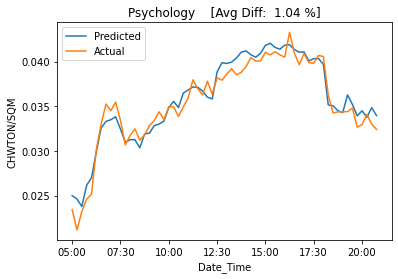

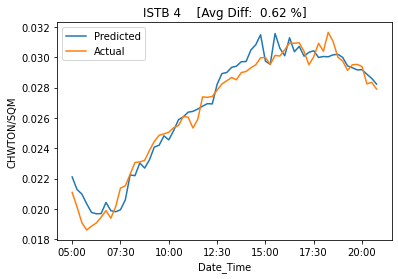

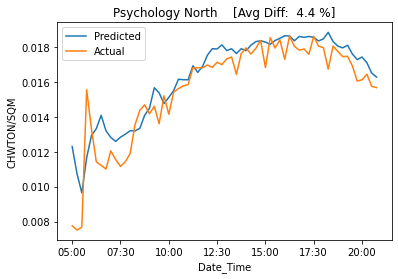

In [23]:
plt_obj = Plot(TRAIN_PATH, TEST_PATH)

# 1. predict
y_pred = model.predict(X_test)

# 2. plot
plt_obj.plot(y_pred, y_test, 
             scene_name="actual", 
             output_path =OUTPUT_PATH, 
             is_scenario=False, 
             is_save=True)


## Get scores for each bldg

In [24]:
# 0. get the df by builidng list
df_bldgs = plt_obj.get_df_bldgs()

# 1. init scoring object
scoring_obj = Scoring()


# 2. compute 3 scores for each bldg
for df_bldg in df_bldgs:
    scoring_obj.compute_R2_MBE_RMSE(df_bldg, MODEL_NAME)
    
# 3. append to df scores
df_scores_per_bldg = scoring_obj.get_df_scores_per_bldg()

# 4. append all scores
scores = [MODEL_NAME, 
                    "all", 
                    scores_all.iloc[0]["r2_test"], 
                    scores_all.iloc[0]["rmse_test"],
                    scores_all.iloc[0]["mbe_test"]
                   ]

df_scores_per_bldg.loc[len(df_scores_per_bldg.index)] = scores
df_scores_per_bldg

,model,bldgname,r2,rmse,mbe
0,catboost_random,Psychology,0.938357,0.001174,0.000369
0,catboost_random,ISTB 4,0.96262,0.000755,0.000165
0,catboost_random,Psychology North,0.784751,0.00129,0.000687
3,catboost_random,all,0.985083,0.001097,0.000407


## 5.2 Air Temp Prediction

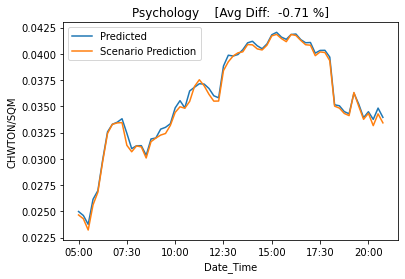

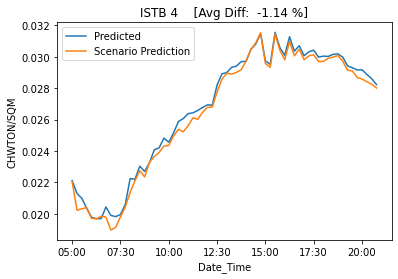

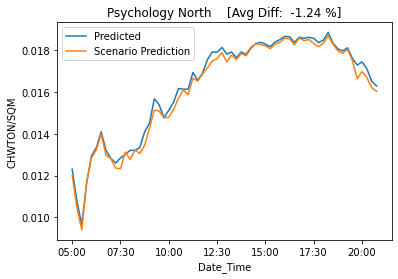

In [25]:
scenario = Scenario(X_test, model)

y_temp_pred = scenario.get_scenario_prediction("Air Temp")
plt_obj.plot(y_pred, y_temp_pred, 
             scene_name="AirTemp", 
             output_path = OUTPUT_PATH, 
             is_scenario = True,
             is_save=True)

## 5.3 Abs Humidity Prediction

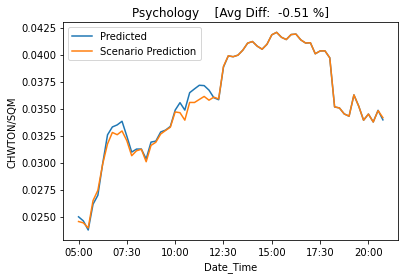

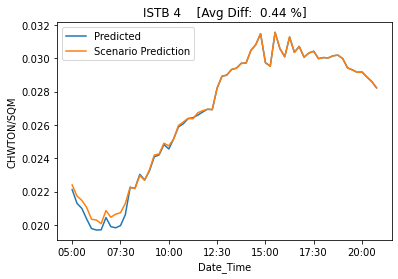

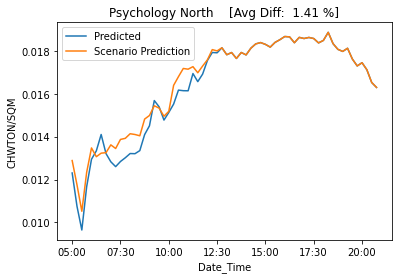

In [26]:
y_hum_pred = scenario.get_scenario_prediction("Abs Hum")
plt_obj.plot(y_pred, y_hum_pred, 
             scene_name="AbsHum", 
             output_path = OUTPUT_PATH, 
             is_scenario = True,
             is_save=True)

## 5.4 Shade West Prediction

shade scenario


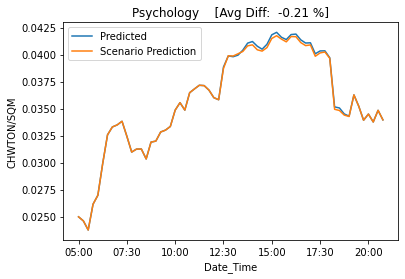

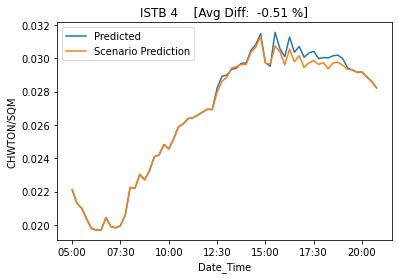

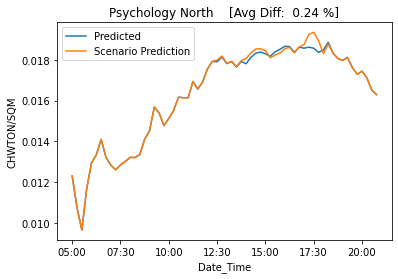

In [27]:
y_shade_west_pred = scenario.get_scenario_prediction("Shade West")
plt_obj.plot(y_pred, y_shade_west_pred, 
             scene_name="ShadeWest", 
             output_path = OUTPUT_PATH, 
             is_scenario = True,
             is_save=True)

## 5.5 Shade East Prediction

shade scenario


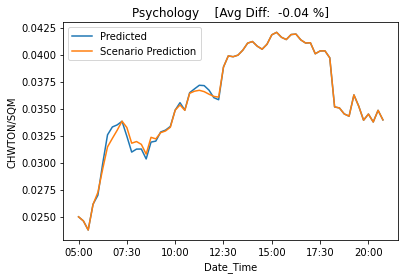

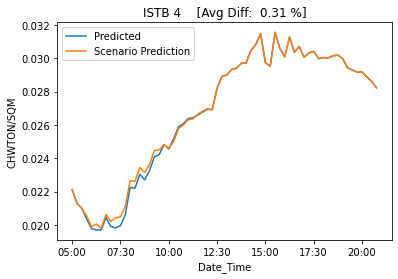

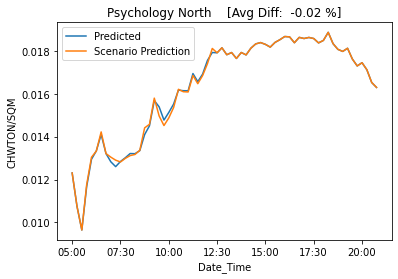

In [28]:
y_shade_east_pred = scenario.get_scenario_prediction("Shade East")
plt_obj.plot(y_pred, y_shade_east_pred, 
             scene_name="ShadeEast", 
             output_path = OUTPUT_PATH, 
             is_scenario = True,
             is_save=True)

## 5.6. Combined Scenarios

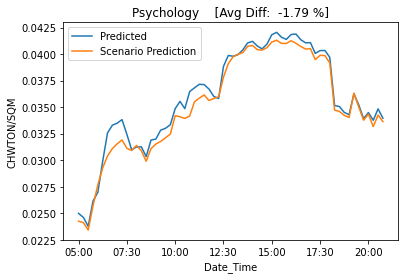

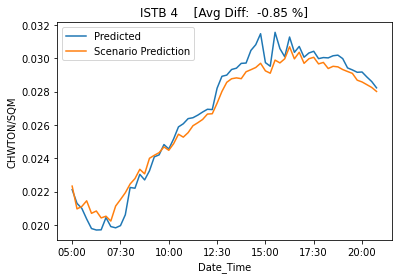

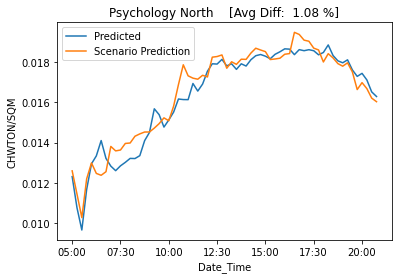

In [29]:
y_combined_pred = scenario.get_scenario_prediction("combined")
plt_obj.plot(y_pred, y_combined_pred, 
             scene_name="combined", 
             output_path = OUTPUT_PATH, 
             is_scenario = True,
             is_save=True)

# 6. Feature Importance

In [ ]:
model.feature_importances_

In [ ]:
## Using Feature Importance
feature_imp= pd.DataFrame(sorted(zip(model.get_feature_importance(), X_train_val.columns), reverse = True), columns = ['Value', 'Feature'])

plt.figure(figsize=(7,5))
sns.barplot(x='Value', y='Feature', data=feature_imp[:20].sort_values(by='Value', ascending=False))
plt.tight_layout()
plt.show()

# 7. SHAP

In [ ]:
# 1. init explainer object
explainer = shap.TreeExplainer(model=model,
                           data=None,
                           model_output='raw',
                           feature_perturbation='tree_path_dependent'
                              )

# 2. get shap values from explainer
shap_values = explainer.shap_values(X_test)

# 3. single sample plot
shap.initjs()
i = 7
shap_vals_round = np.array([np.round(x, 3) for x in shap_values[i,:]] )

shap.force_plot(round(explainer.expected_value,3), 
                shap_vals_round, 
                X_test.iloc[i,:].round(decimals = 2), matplotlib = True)

# 4. visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X_test)



In [ ]:
# 5. summary plot
shap.summary_plot(shap_values, X_test, plot_size = [8,6], show = False)
plt.gcf().axes[-1].set_aspect(10)
plt.gcf().axes[-1].set_box_aspect(10)